In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.2 MB/s eta 0:00:00


In [2]:

import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv   # GAT layer
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, "Torch:", torch.__version__)


Device: cuda Torch: 2.8.0+cu126


# Synthetic SDVN dataset generator (vehicular density features)

This simulates vehicles with (x,y), speed, local density, acceleration, and computes a synthetic label: e.g., "link reliability / path quality" per node

In [3]:

def generate_vehicular_graph(num_nodes=500, area_size=1000, k=6, seed=42):
    np.random.seed(seed)
    # Random positions
    positions = np.random.rand(num_nodes, 2) * area_size  # x,y in area
    # Speeds (m/s)
    speeds = np.random.normal(loc=15, scale=5, size=(num_nodes, 1))
    speeds = np.clip(speeds, 0.1, None)
    # Acceleration random
    acc = np.random.normal(0, 1, size=(num_nodes,1))
    # Local density: count vehicles within radius R (normalized)
    R = area_size * 0.08
    dists = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=-1)
    density = (dists < R).sum(axis=1, keepdims=True) / num_nodes  # normalized density
    # Path features could include cluster-level param; here we add degree estimate
    # Node features: [x_norm, y_norm, speed_norm, acc_norm, density]
    x_norm = positions / area_size
    y_norm = positions[:,1:2] / area_size
    features = np.hstack([x_norm, y_norm, speeds / speeds.max(), (acc - acc.mean())/ (acc.std()+1e-6), density])
    # Build adjacency via kNN graph (sparse)
    A = kneighbors_graph(positions, n_neighbors=k, include_self=False).toarray()
    # Convert to edge_index (PyG format)
    src, dst = np.where(A > 0)
    edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)
    # Synthetic label: e.g., per-node probability of link surviving -> higher if density moderate & speed lower
    # craft a target function: reliability = sigmoid( w1*(1-density) + w2*(1/speed) + noise )
    w1, w2 = 2.0, 5.0
    density_flat = density.ravel()
    speed_flat = speeds.ravel()
    rel_score = 1 / (1 + np.exp(-(w1*(1-density_flat) + w2*(1/(speed_flat+1e-6)) - 2.5 + np.random.randn(num_nodes)*0.1)))
    y = rel_score.reshape(-1,1).astype(np.float32)  # regression label
    # Wrap in torch tensors
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    data.pos = torch.tensor(positions, dtype=torch.float)
    return data

# Example
data = generate_vehicular_graph(num_nodes=800, area_size=2000, k=8)
print(data)


Data(x=[800, 6], edge_index=[2, 6400], y=[800, 1], pos=[800, 2])


# Create dataset + dataloaders (split nodes into train/val/test)

In [4]:

def prepare_masks(data, train_frac=0.6, val_frac=0.2, seed=42):
    num_nodes = data.x.size(0)
    idx = np.arange(num_nodes)
    train_idx, temp_idx = train_test_split(idx, train_size=train_frac, random_state=seed)
    val_relative = val_frac / (1 - train_frac)
    val_idx, test_idx = train_test_split(temp_idx, train_size=val_relative, random_state=seed)
    mask = {}
    mask['train_mask'] = torch.zeros(num_nodes, dtype=torch.bool)
    mask['val_mask'] = torch.zeros(num_nodes, dtype=torch.bool)
    mask['test_mask'] = torch.zeros(num_nodes, dtype=torch.bool)
    mask['train_mask'][train_idx] = True
    mask['val_mask'][val_idx] = True
    mask['test_mask'][test_idx] = True
    data.train_mask = mask['train_mask']
    data.val_mask = mask['val_mask']
    data.test_mask = mask['test_mask']
    return data

data = prepare_masks(data)
print("Train/Val/Test counts:", data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item())


Train/Val/Test counts: 480 160 160


# GAT model (multi-layer, multi-head)

In [5]:

class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=1, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # after heads, features = hidden_channels * heads
        self.lin = torch.nn.Linear(hidden_channels * heads, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.lin(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze(dim=-1)  # shape: [num_nodes]

# instantiate
model = GATNet(in_channels=data.x.size(1), hidden_channels=64, out_channels=1, heads=4, dropout=0.2).to(device)
print(model)


GATNet(
  (conv1): GATConv(6, 64, heads=4)
  (lin): Linear(in_features=256, out_features=64, bias=True)
  (conv2): GATConv(64, 1, heads=1)
)


# Training loop (node-level regression)

In [6]:

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    train_mask = data.train_mask.to(device)
    loss = criterion(out[train_mask], data.y.squeeze(1).to(device)[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    y_true = data.y.squeeze(1).to(device)
    y_pred = out
    mse = F.mse_loss(y_pred[mask], y_true[mask]).item()
    mae = F.l1_loss(y_pred[mask], y_true[mask]).item()
    return mse, mae

# training run
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

data = data.to(device)
epochs = 150
history = {'train_loss': [], 'val_mse': [], 'val_mae': []}

for epoch in range(1, epochs+1):
    loss = train(model, data, optimizer, criterion)
    val_mse, val_mae = evaluate(model, data, data.val_mask.to(device))
    history['train_loss'].append(loss)
    history['val_mse'].append(val_mse)
    history['val_mae'].append(val_mae)
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val MSE: {val_mse:.4f} | Val MAE: {val_mae:.4f}")


Epoch 001 | Train Loss: 0.2394 | Val MSE: 0.0761 | Val MAE: 0.2605
Epoch 025 | Train Loss: 0.0159 | Val MSE: 0.0050 | Val MAE: 0.0457
Epoch 050 | Train Loss: 0.0164 | Val MSE: 0.0047 | Val MAE: 0.0448
Epoch 075 | Train Loss: 0.0161 | Val MSE: 0.0049 | Val MAE: 0.0453
Epoch 100 | Train Loss: 0.0151 | Val MSE: 0.0041 | Val MAE: 0.0401
Epoch 125 | Train Loss: 0.0130 | Val MSE: 0.0040 | Val MAE: 0.0396
Epoch 150 | Train Loss: 0.0121 | Val MSE: 0.0035 | Val MAE: 0.0363


# Test performance

Test MSE: 0.0019982450176030397 Test MAE: 0.035256825387477875


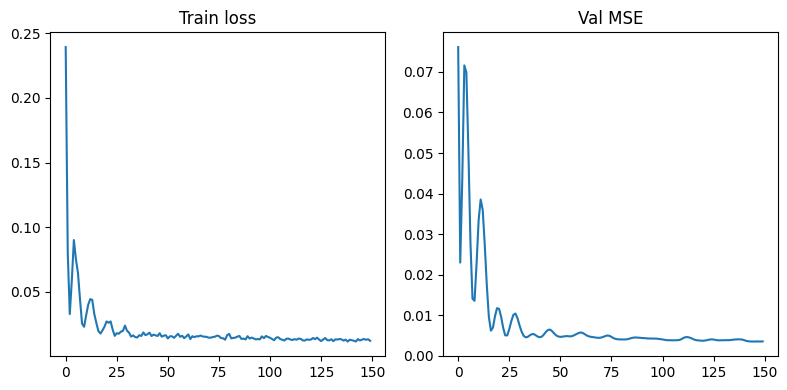

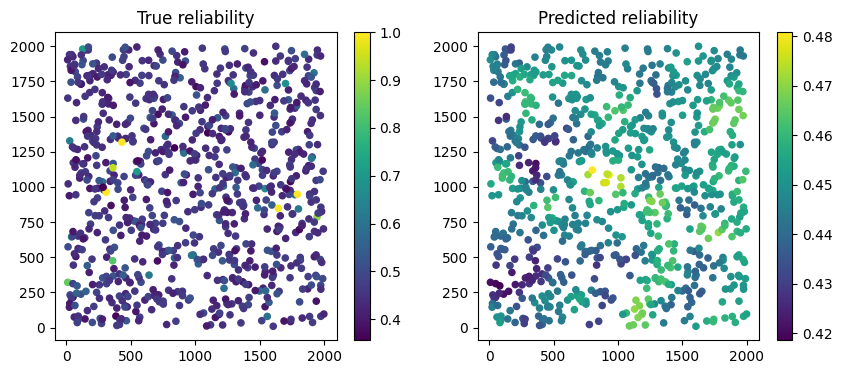

In [7]:

test_mse, test_mae = evaluate(model, data, data.test_mask.to(device))
print("Test MSE:", test_mse, "Test MAE:", test_mae)

# plot training history
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'])
plt.title('Train loss')
plt.subplot(1,2,2)
plt.plot(history['val_mse'])
plt.title('Val MSE')
plt.tight_layout()
plt.show()

# Visualize predicted reliability over 2D positions
pos = data.pos.cpu().numpy()
y_true = data.y.squeeze(1).cpu().numpy()
with torch.no_grad():
    preds = model(data.x.to(device), data.edge_index.to(device)).cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(pos[:,0], pos[:,1], c=y_true, s=20)
plt.title('True reliability')
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(pos[:,0], pos[:,1], c=preds, s=20)
plt.title('Predicted reliability')
plt.colorbar()
plt.show()
